# HYBRID MULTILAYER LSTM MODEL

## 1. Import statements

**Import necessary packages and modules**

In [1]:
import os
import time
import random
import math
import json
import pandas as pd
import numpy as np
import tensorflow as tf
import progressbar
tf.reset_default_graph()
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

**Import gensim**

In [2]:
from gensim.models.word2vec import Word2VecKeyedVectors

**Set the random seed of numpy and tensorflow**

In [3]:
# np_rand_seed = random.randint(0,100)
# tf_rand_seed = random.randint(0,100)
np_rand_seed = 95
tf_rand_seed = 63
np.random.seed(np_rand_seed)
print("numpy random seed: ",np_rand_seed)
print("tensorflow random seed: ", tf_rand_seed)

numpy random seed:  95
tensorflow random seed:  63


## 2. Load train data, test data, and gensim word2vec model

**Set some directories**

In [4]:
input_dir = "../input/amazon_review_polarity_csv/"
word2vec_dir = "./word2vec_models/"
model_dir = "./model_files/"
submission_dir = "./submission_dir/"

**Load the cleaned train and test data**

In [5]:
data = pd.read_csv(input_dir+'train_data_processed.csv') 
test_data = pd.read_csv(input_dir+'test_data_processed.csv')

In [6]:
data.head()

,sentiment,review_title,review_text
0,1,stune even non gamer,sound track beauti paint seneri mind well woul...
1,1,best soundtrack ever anyth,read lot review sai best game soundtrack figur...
2,1,amaz,soundtrack favorit music time hand intens sad ...
3,1,excel soundtrack,truli like soundtrack enjoi video game music p...
4,1,rememb pull jaw floor hear,plai game know divin music everi singl song te...


In [7]:
test_data.head()

,sentiment,review_title,review_text
0,1,great cd,love pat on great voic gener listen cd year st...
1,1,on best game music soundtrack game realli plai,despit fact plai small portion game music hear...
2,0,batteri di within year,bought charger jul 2003 work ok design nice co...
3,1,work fine maha energi better,check maha energi websit powerex mh c204f char...
4,1,great non audiophil,review quit bit combo player hesit due unfavor...


Unfortunately the csv loader function has problems, it occassionaly shows up null values for text columns. It is advised to get rid of the null values.

In [8]:
data = data.sample(frac=1,  random_state = np.random.seed()).reset_index(drop=True)
data = data[~data['review_title'].isnull()]
test_data = test_data[~test_data['review_title'].isnull()]
data = data[~data['review_text'].isnull()]
test_data = test_data[~test_data['review_text'].isnull()]

**Load the gensim model**

In [9]:
size = 300
window = 20
fname = "word2vec_size_"+str(size)+"_window_"+str(window)+".mdl"
model = Word2VecKeyedVectors.load_word2vec_format(word2vec_dir+fname)

## 3. Check the balance of the labels

**Extract the positive and negative sentiment examples**

In [10]:
pos_sent = data[data['sentiment'] == 1].shape[0]
neg_sent = data[data['sentiment'] == 0].shape[0]

**Bar chart of the balance of the sentiments**

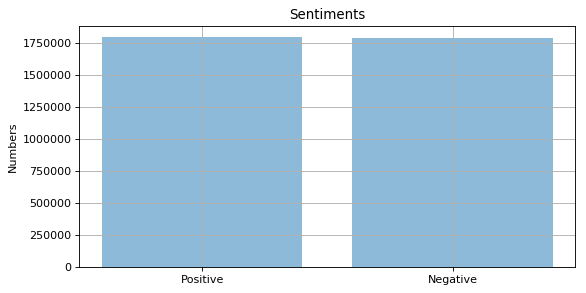

In [11]:
numbers = [pos_sent, neg_sent]
plt.figure(figsize=(8, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(np.arange(len(numbers)), numbers, align='center', alpha=0.5)
plt.xticks(np.arange(len(numbers)),\
           ['Positive', 'Negative'])
plt.ylabel('Numbers')
plt.title('Sentiments')
plt.grid()
plt.show()

## 4. Inspect the distribution of #words in the text

**A function to find the length of text**

In [12]:
def find_length(text):
    """
    A function to find the length of text
    """
    text = str(text)
    return len(text.split())

### 4.1 Distribution of #words in the review titles

**Find the length of review titles in train and test data**

In [13]:
data['length_title'] = data['review_title'].apply(find_length)
test_data['length_title'] = test_data['review_title'].apply(find_length)

**Distribution of #words in review titles in train data**

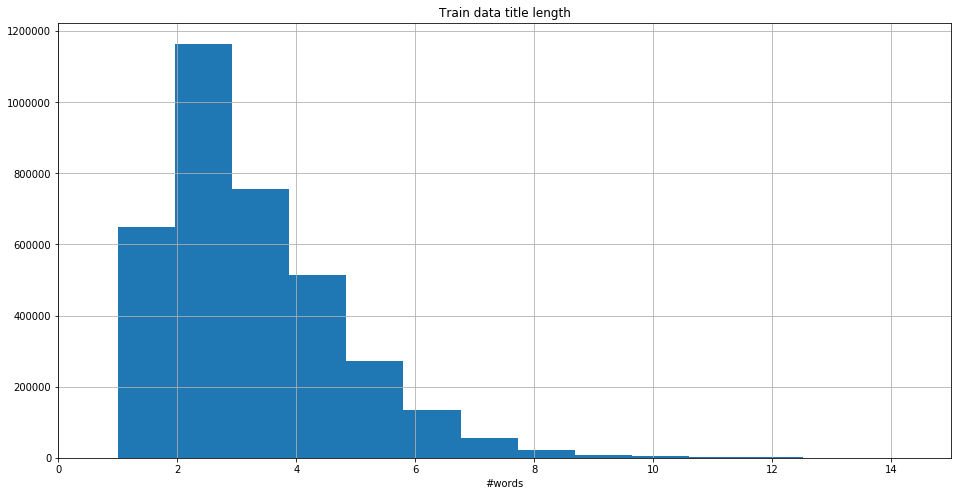

In [14]:
data.hist("length_title", bins=25, figsize=(16,8))
plt.title("Train data title length")
plt.xlabel("#words")
plt.xlim(0,15)
plt.show()

**Distribution of #words in review titles in test data**

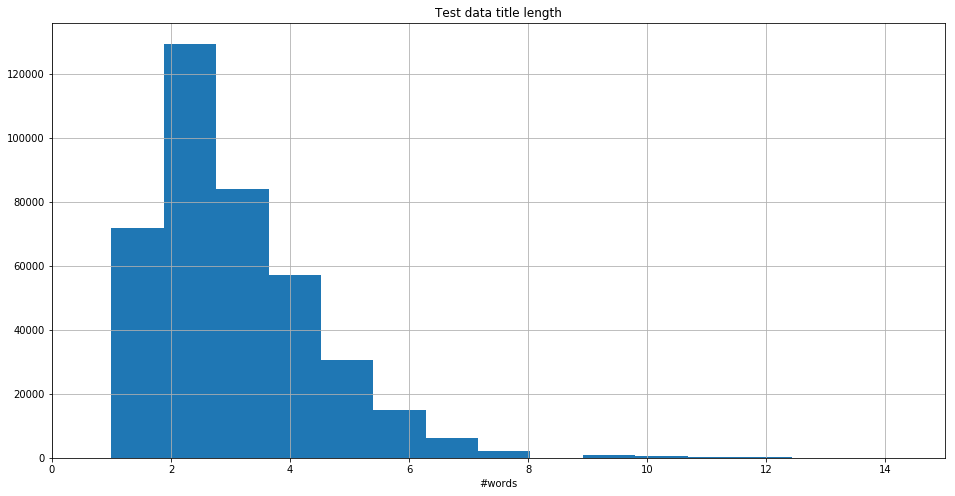

In [15]:
test_data.hist("length_title", bins=25, figsize=(16,8))
plt.title("Test data title length")
plt.xlabel("#words")
plt.xlim(0,15)
plt.show()

**Distribution of #words in review titles in all data**

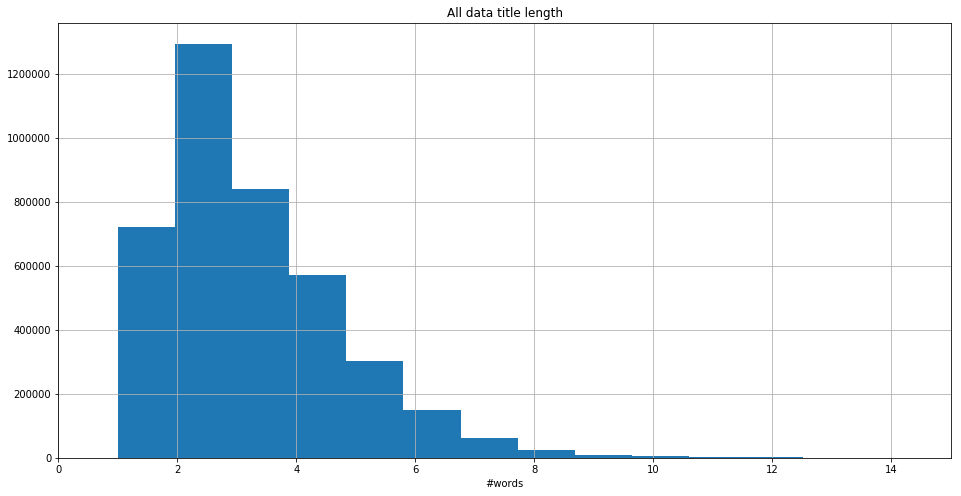

In [16]:
all_length = pd.concat([data['length_title'], test_data['length_title']])
all_length.hist(bins=25, figsize=(16,8))
plt.title("All data title length")
plt.xlim(0,15)
plt.xlabel("#words")
plt.show()
del(all_length)

### 4.3 distribution of #words in the review text

**Find the length of review titles in train and test data**

In [17]:
data['length_text'] = data['review_text'].apply(find_length)
test_data['length_text'] = test_data['review_text'].apply(find_length)

**Distribution of #words in review text in train data**

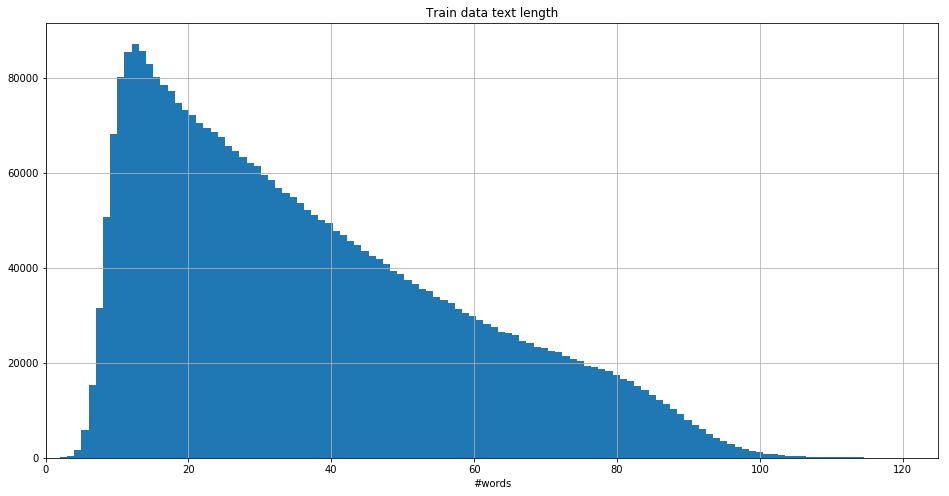

In [18]:
data.hist("length_text", bins=200, figsize=(16,8))
plt.title("Train data text length")
plt.xlabel("#words")
plt.xlim(0,125)
plt.show()

**Distribution of #words in review text in test data**

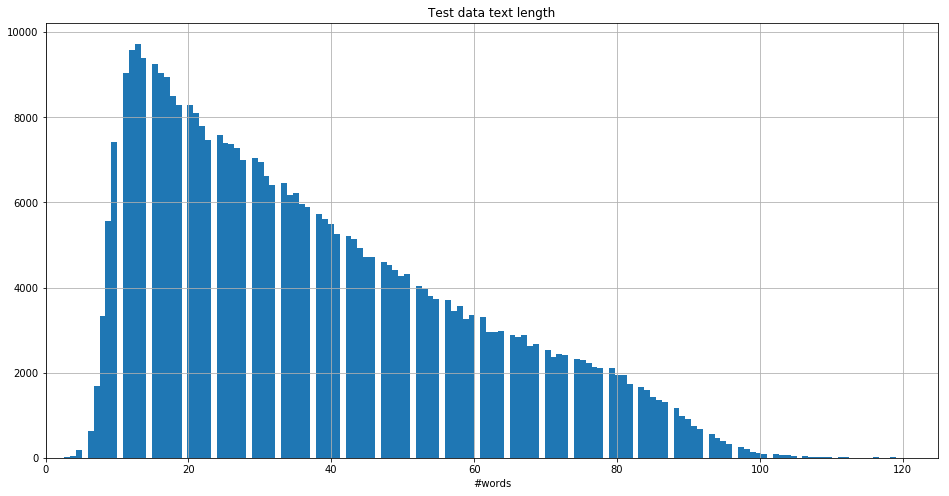

In [19]:
test_data.hist("length_text", bins=200, figsize=(16,8))
plt.title("Test data text length")
plt.xlabel("#words")
plt.xlim(0,125)
plt.show()

**Distribution of #words in review text in all data**

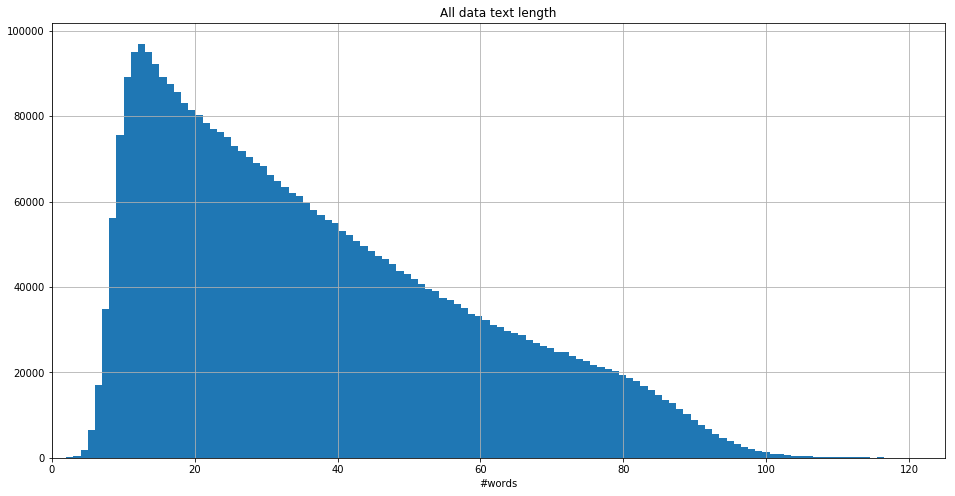

In [20]:
all_length = pd.concat([data['length_text'], test_data['length_text']])
all_length.hist(bins=200, figsize=(16,8))
plt.title("All data text length")
plt.xlim(0,125)
plt.xlabel("#words")
plt.show()
del(all_length)

**Split the training set into train and validation sets and save the sets**

In [21]:
test_size = test_data.shape[0]
test_data.to_csv(input_dir+"test_data.csv",header=True, index=False)
del(test_data)
train_percentage = 0.999
train_data = data.head(int(len(data)*train_percentage))
train_data.to_csv(input_dir+"train_data.csv",header=True, index=False)
del(train_data)
valid_data = data.tail(len(data)-int(len(data)*train_percentage))
valid_size = len(valid_data)
valid_data.to_csv(input_dir+"valid_data.csv",header=True, index=False)
del(valid_data)
del(data)

## 5. Input functions

**A function to generate sequence of embeddings for the text columns**

In [22]:
def sequence_generator(comments, max_length, size):
    """
    A function to generate sequence of embeddings for the text columns
    """    
    sentences = []
    for comment in comments.tolist():
        sentences.append(str(comment).split())
        
    sequences = []
    for sentence in sentences:
        if len(sentence)>0:
            if len(sentence)<max_length:
                sequence = model[sentence]
                tail = np.zeros((max_length - len(sentence), size))
                sequence = np.concatenate((sequence, tail))
            else:
                sequence = model[sentence[:max_length]]
        else:
            sequence = np.zeros((max_length, size))        
        sequences.append(sequence)
    sequences = np.array(sequences)
    
    return sequences

**A function to generate batch of embeddings sequence, sequence length, and one hot encode output**

In [23]:
def generate_batch(reader, csv_path, batch_size, 
                   max_length_review, max_length_title,
                   size_1, size_2, train_set=True):
    """
    A function to generate batch of embeddings sequence, sequence length, and one hot encode output
    """
    # read batch
    try:
        batch = reader.get_chunk()
    except:
        
        reader = pd.read_csv(csv_path, chunksize=batch_size)
        batch = reader.get_chunk()
    
    # extract columns of review title, review text, and their lengths from the batch data
    review_title_batch = batch["review_title"].values
    review_text_batch = batch["review_text"].values
    review_title_length = batch["length_title"].apply(find_length).values
    review_text_length = batch["length_text"].apply(find_length).values
    
    # if it is train set then extract the columns of sentiments
    if train_set:
        sentiments_batch = np.eye(2)[batch['sentiment'].values]
        
    # generate sequences of embeddings for the columns of review title and review texts
    sequences_title_batch = sequence_generator(review_title_batch, max_length_title, size_1)
    sequences_review_batch = sequence_generator(review_text_batch, max_length_review, size_2)
    
    # return statement
    if train_set:
        return sequences_review_batch, sequences_title_batch, review_text_length, review_title_length, sentiments_batch
    else:
        return sequences_review_batch, sequences_title_batch, review_text_length, review_title_length

## 6. Class module of hybrid multilayer lstm model

In [24]:
class multilayer_lstm_model(object):
    """
    Multilayer lstm model
    """    
    def __init__(self, n_steps_1, n_steps_2, n_inputs_1, n_inputs_2, n_outputs, 
                 n_layers_1, n_layers_2, n_neurons_1, n_neurons_2, dense_layers, learning_rate,
                 device, tf_seed, np_seed):
        """
        Class constuctor which intializes the parameters, placeholders, and operations of the model
        """
        
        # parameters of lstm model
        self.n_steps_1 = n_steps_1
        self.n_steps_2 = n_steps_2
        self.n_inputs_1 = n_inputs_1
        self.n_inputs_2 = n_inputs_2
        self.n_outputs = n_outputs
        self.n_layers_1 = n_layers_1
        self.n_layers_2 = n_layers_2
        self.n_neurons_1 = n_neurons_1
        self.n_neurons_2 = n_neurons_2
        self.dense_layers = dense_layers
        self.learning_rate = learning_rate
        self.device = device
        self.tf_seed = tf_seed
        self.np_seed = np_seed    
        
        # placeholders and operations
        self.X1 = None
        self.X2 = None
        self.Y = None
        self.Length1 = None
        self.Length2 = None
        self.keep_prob = None
        self.Y_ = None
        self.accuracy = None
        self.cost = None
        self.train_step = None
        
        # create model
        self.X1, self.X2, self.Y, self.Length1, self.Length2, self.keep_prob, \
        self.Y_, self.accuracy, self.cost, self.train_step = self.create_model()
        
        self.saver = None
        self.train_cost = None
        self.valid_cost = None
        self.valid_accuracy = None
        self.best_valid_accuracy = None
        self.best_iteration = None
        self.best_time = None
        self.log_of_computation_time = []
        
        
    def bidirectional_lstm(self, X, n_layers, n_neurons, keep_prob, device, name):
        
        """
        Method to create multilayer biderectional lstm model
        """
        output = X
        # iterate through the layers of LSTM
        for layer in range(n_layers):
            with tf.variable_scope(name+'Layer{}'.format(layer),reuse=tf.AUTO_REUSE):
                # forward lstm cell
                cell_fw = tf.nn.rnn_cell.LSTMCell(n_neurons,
                                                  initializer=tf.variance_scaling_initializer())
                # dropout on lstm cell
                cell_fw = tf.nn.rnn_cell.DropoutWrapper(cell_fw, input_keep_prob = keep_prob)
                # mount the lstm cell on gpu
                cell_fw = tf.nn.rnn_cell.DeviceWrapper(cell_fw,device) 
                # backward lstm cell
                cell_bw = tf.nn.rnn_cell.LSTMCell(n_neurons,
                                                  initializer=tf.variance_scaling_initializer())
                # dropout on lstm cell
                cell_bw = tf.nn.rnn_cell.DropoutWrapper(cell_bw, input_keep_prob = keep_prob)
                # mount the lstm cell on gpu
                cell_bw = tf.nn.rnn_cell.DeviceWrapper(cell_bw,device) 
                # extract the outputs and states bidirectional lstm
                outputs, states = tf.nn.bidirectional_dynamic_rnn(cell_fw, 
                                                                  cell_bw, 
                                                                  output,
                                                                  dtype=tf.float32)
                # concat the outputs of bidirectional lstm
                output = tf.concat(outputs,2)
        
        # concat the top layer h states of bidirection lstm 
        state = tf.concat([states[0][-1], states[1][-1]], axis=-1)

        return output, state
        
        
    def create_model(self):
        """
        A method to create the multilayer lstm model
        """
        # placeholder to store the review text
        X1 = tf.placeholder(tf.float32, [None, self.n_steps_1, self.n_inputs_1])
        # placeholder to store the review title
        X2 = tf.placeholder(tf.float32, [None, self.n_steps_2, self.n_inputs_2])
        # placeholder to store the output of the model
        Y = tf.placeholder(tf.float32, [None, self.n_outputs])
        # placeholder to store the lengths of the review text
        Length1 = tf.placeholder(tf.int32, [None])
        # placeholder to store the lengths of the review title
        Length2 = tf.placeholder(tf.int32, [None])
        # keep probability for dropout
        keep_prob = tf.placeholder(tf.float32)
            
        # created bidrectional lstm and extract the top layer h state
        _, top_layer_h_state_1 = self.bidirectional_lstm(X1, self.n_layers_1, self.n_neurons_1,
                                                         keep_prob, self.device, "LSTM1")
        
            
        # created bidrectional lstm and extract the top layer h state
        _, top_layer_h_state_2 = self.bidirectional_lstm(X2, self.n_layers_2, self.n_neurons_2,
                                                         keep_prob, self.device, "LSTM2")
        
        # iterate and create the dense layer
        for n, dense_layer in enumerate(self.dense_layers):
            # first dense layer (with dropout)
            if n == 0:
                with tf.device(self.device):
                    dense_1 = tf.layers.dense(top_layer_h_state_1, dense_layer,
                                              kernel_initializer=tf.variance_scaling_initializer(),
                                              activation=tf.nn.elu)
                    dense_2 = tf.layers.dense(top_layer_h_state_2, dense_layer,
                                              kernel_initializer=tf.variance_scaling_initializer(),
                                              activation=tf.nn.elu)
                    dense = tf.concat([dense_1, dense_2], axis = 1)
                    dense = tf.nn.dropout(dense, keep_prob=keep_prob)
            # last dense layer (without dropout)
            elif n == len(self.dense_layers)-1:
                with tf.device(self.device):
                    dense = tf.layers.dense(dense, dense_layer,
                                            kernel_initializer=tf.variance_scaling_initializer())
            # middle dense layers (with droput)
            else:
                with tf.device(self.device):
                    dense = tf.layers.dense(dense, dense_layer, 
                                            kernel_initializer=tf.variance_scaling_initializer(),
                                            activation=tf.nn.elu)
                    dense = tf.nn.dropout(dense, keep_prob=keep_prob)
                    
        
        # compute predicted class
        Y_ = tf.argmax(dense, axis=1, output_type=tf.int32)
        # compute true class
        Y_true_cls = tf.argmax(Y, axis=1, output_type=tf.int32)
        # compute correct prediction
        correct_prediction = tf.equal(Y_, Y_true_cls)
        # compute accuracy
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        # cost
        with tf.device(device):
            cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=dense,labels=Y)
            cost = tf.reduce_mean(cross_entropy)

        # train step
        with tf.device(device):
            train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)        
        
        return X1, X2, Y, Length1, Length2, keep_prob, Y_, accuracy, cost, train_step
    
    
    def train_model(self, max_iter, batch_size, drop_prob,
                    train_data_reader,valid_data_reader,train_path, valid_path,
                    size, model_dir, model_name, generate_batch):
        """
        A method to train the multilayer lstm model
        """        
        # generate sequences, length, & sentimentas for validation set
        sequences_review_valid, sequences_title_valid, review_text_length_valid, review_title_length_valid, sentiments_valid = \
        generate_batch(valid_data_reader, valid_path, valid_data_reader.chunksize,
                       self.n_steps_1, self.n_steps_2, self.n_inputs_1, self.n_inputs_2)
        # feed dict for validation
        feed_dict_validation =  {self.X1:sequences_review_valid,
                                 self.X2:sequences_title_valid,
                                 self.Y:sentiments_valid,
                                 self.Length1:review_text_length_valid,
                                 self.Length2:review_title_length_valid,
                                 self.keep_prob: 1.0} 
        
        # start time
        start_time = time.time()
        # create a saver object
        saver = tf.train.Saver(max_to_keep=1)
        # lists to store the train cost, validation cost, and validation accuracy
        train_cost = []
        valid_cost = []
        valid_accuracy = []
        # variables to store the best roc and best iteration
        # and the time to reach the best roc
        best_valid_accuracy = 0
        best_iteration = None
        best_time = None
        # path of model saver object
        model_path = model_dir+model_name
        
        # create a graph session and optimize the network under it
        with tf.Session() as sess:
            # set random seed of tensorflow and numpy
            tf.set_random_seed(self.tf_seed)
            np.random.seed(self.np_seed)            
        
            # initialize global and local variables
            sess.run(tf.global_variables_initializer())
            sess.run(tf.local_variables_initializer())
            
            # create an object of progress bar
            bar = progressbar.ProgressBar(maxval=max_iter, widgets=[
                '[',progressbar.Percentage(),']',
                progressbar.Bar(),
                '(',progressbar.DynamicMessage("train_cost"),')',
                '(',progressbar.DynamicMessage("valid_cost"),')',
                '(',progressbar.DynamicMessage("valid_accuracy"),')',
                '(',progressbar.DynamicMessage("best_valid_accuracy"),')',
                '(',progressbar.DynamicMessage("time_elapsed"),'mins)'
            ])
            # start the progress bar
            bar.start()
            # counter variable to track the number of iterations
            counter = 0
            # iterate until maximum number of iterations is reached
            while True:
                # break out of the inner for loop if maximum number of iterations is reached
                if counter>=max_iter:
                    break            
                # generate sequences, length, & sentimentas for train batch
                sequences_review_batch, sequences_title_batch, review_text_length_batch, \
                review_title_length_batch, sentiments_batch = \
                generate_batch(train_data_reader, train_path, train_data_reader.chunksize,
                               self.n_steps_1, self.n_steps_2, self.n_inputs_1, self.n_inputs_2)
                # feed dict for validation
                feed_dict_batch =  {self.X1:sequences_review_batch,
                                    self.X2:sequences_title_batch,
                                    self.Y:sentiments_batch,
                                    self.Length1:review_text_length_batch,
                                    self.Length2:review_title_length_batch,
                                    self.keep_prob: drop_prob}
                # execute optimization step
                sess.run(self.train_step, feed_dict=feed_dict_batch)
                # calculate temporary train cost and append it to the designated list
                temp_train_cost = self.cost.eval(session=sess, feed_dict=feed_dict_batch)
                train_cost.append(temp_train_cost)
                # calculate temporary validation cost and append it to the designated list
                temp_valid_cost = self.cost.eval(session=sess, feed_dict=feed_dict_validation)
                valid_cost.append(temp_valid_cost)
                # calculate temporary validation cost and append it to the designated list
                temp_valid_acc = self.accuracy.eval(session=sess, feed_dict=feed_dict_validation)
                valid_accuracy.append(temp_valid_acc)
                # compute running time from start point
                time_diff = (time.time()-start_time)/60
                # append elapsed time to the designated list
                self.log_of_computation_time.append(time_diff)
                # if valid cost is better than best recorded so far then
                # update the parameters of the best model and save the model
                if temp_valid_acc > best_valid_accuracy:
                    best_time = time_diff
                    best_valid_accuracy = temp_valid_acc
                    best_iteration = counter+1
                    saver.save(sess, model_path, global_step = best_iteration)
                    
                # store the required variables, placeholders and operations in designated class fields
                self.saver = saver
                self.train_cost = train_cost
                self.valid_cost = valid_cost
                self.best_valid_accuracy = best_valid_accuracy
                self.valid_accuracy = valid_accuracy
                self.best_iteration = best_iteration
                self.best_time = best_time

                # update the progress bar
                bar.update(counter+1, train_cost = temp_train_cost, 
                           valid_cost = temp_valid_cost,
                           valid_accuracy = temp_valid_acc, 
                           best_valid_accuracy = best_valid_accuracy, 
                           time_elapsed = time_diff)
                # increment counter variable
                counter += 1

            # finish the progress bar
            bar.finish() 
            
            
    def create_predictions(self, model_path, test_data_reader, test_path, 
                           n_folds, submission_dir, submission_file, generate_batch):
        '''
        A function to compute predictions and submission file
        '''
        # submission path
        submission_path = submission_dir + submission_file

        with tf.Session() as sess: 
            # restore the best model
            self.saver.restore(sess, model_path)
            # array to store the prediction
            preds = np.array([])
            # create a progress bar object
            bar = progressbar.ProgressBar(maxval=n_folds, widgets=[
                            '[',progressbar.Percentage(),']',
                            progressbar.Bar(),
                            '(',progressbar.DynamicMessage("number_of_folds_completed"),')'
                        ])            
            # start progress bat
            bar.start()
            
            # iterate through each fold
            for i in range(n_folds):
                # generate sequences, length, & sentiments for test set
                sequences_review_test, sequences_title_test, review_text_length_test, review_title_length_test = \
                generate_batch(test_data_reader, test_path, test_data_reader.chunksize,
                               self.n_steps_1, self.n_steps_2, self.n_inputs_1, self.n_inputs_2, train_set=False)
                # feed dict for test
                feed_dict_test =  {self.X1:sequences_review_test,
                                   self.X2:sequences_title_test,
                                   self.Length1:review_text_length_test,
                                   self.Length2:review_title_length_test,
                                   self.keep_prob: 1.0}
                # evaluate predictions of the fold
                fold_preds = self.Y_.eval(session=sess, feed_dict = feed_dict_test)
                # append it to designated array
                preds = np.append(preds, fold_preds)                    
                # update the progress bar
                bar.update(i+1, number_of_folds_completed = i+1)                
            # finish the progress bar
            bar.finish()

            submission = pd.DataFrame({"sentiments": preds})
            submission.to_csv(submission_path, header = True, index=False)

## 7. Create graph of multilayer lstm model

**Inspect the devices of kernel**

In [25]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
print(devices)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16460752721581923135
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16007175043254451476
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7242182814743901727
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15864391271
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6626937596118796485
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


**Set the device to gpu if available**

In [26]:
if len(devices)>1:
    device = devices[-1].name
else:
    device = devices[0].name

**Create graph**

In [27]:
n_layers_1 = 2
n_layers_2 = 2
n_neurons_1 = 256
n_neurons_2 = 64
max_length_1 = n_steps_1 = 120
max_length_2 = n_steps_2 = 15
n_inputs_1 = size
n_inputs_2 = size
n_outputs = 2
dense_layers = [64, n_outputs]
learning_rate = (1e-3)*5
tf.reset_default_graph()
sequence_model = multilayer_lstm_model(n_steps_1, n_steps_2, n_inputs_1, n_inputs_2, n_outputs, 
                                       n_layers_1, n_layers_2, n_neurons_1, n_neurons_2, 
                                       dense_layers, learning_rate,
                                       device, tf_rand_seed, np_rand_seed)

## 8. Train multilayer lstm model

**Train model**

In [28]:
max_iter = 1000
batch_size = 400
keep_prob = 0.50
train_path = input_dir+"train_data.csv"
train_data_reader = pd.read_csv(train_path, chunksize=batch_size)
valid_path = input_dir+"valid_data.csv"
valid_data_reader = pd.read_csv(valid_path, chunksize=valid_size)
model_name = "hybrid_multilayer_lstm" 
sequence_model.train_model(max_iter, batch_size, keep_prob,
                           train_data_reader,valid_data_reader,train_path, valid_path,
                           size, model_dir, model_name, generate_batch)

[100%]||(train_cost:  0.229)(valid_cost:  0.251)(valid_accuracy:    0.9)(best_valid_accuracy:  0.906)(time_elapsed:   57.1mins)


**Plot of cost vs iterations**

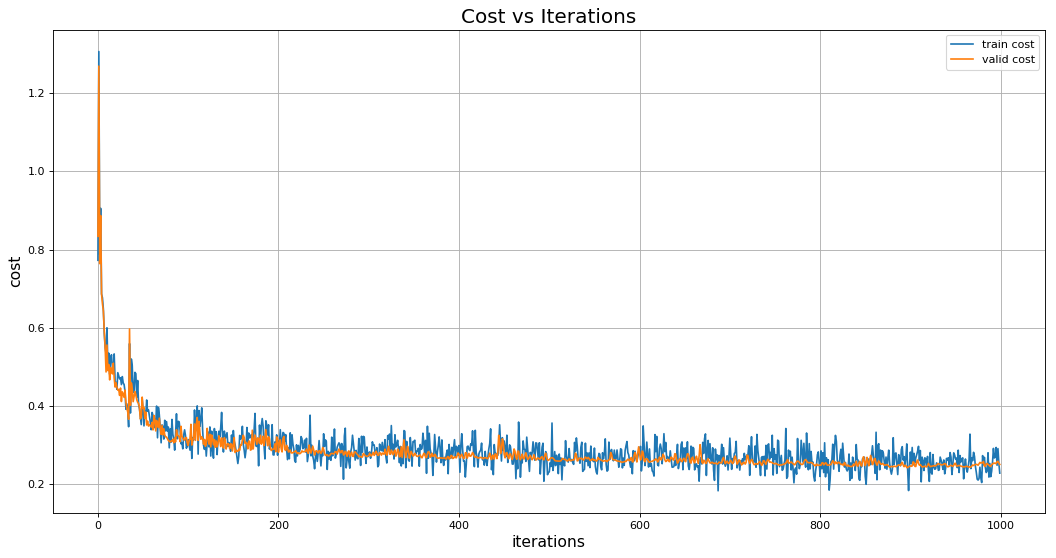

In [29]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(sequence_model.train_cost, label = 'train cost')
plt.plot(sequence_model.valid_cost, label = 'valid cost')
plt.xlabel('iterations', fontsize = 14)
plt.ylabel('cost', fontsize = 14)
plt.title("Cost vs Iterations",fontsize = 18)
plt.legend()
plt.grid()
plt.show()

**Plot of accuracy vs iterations**

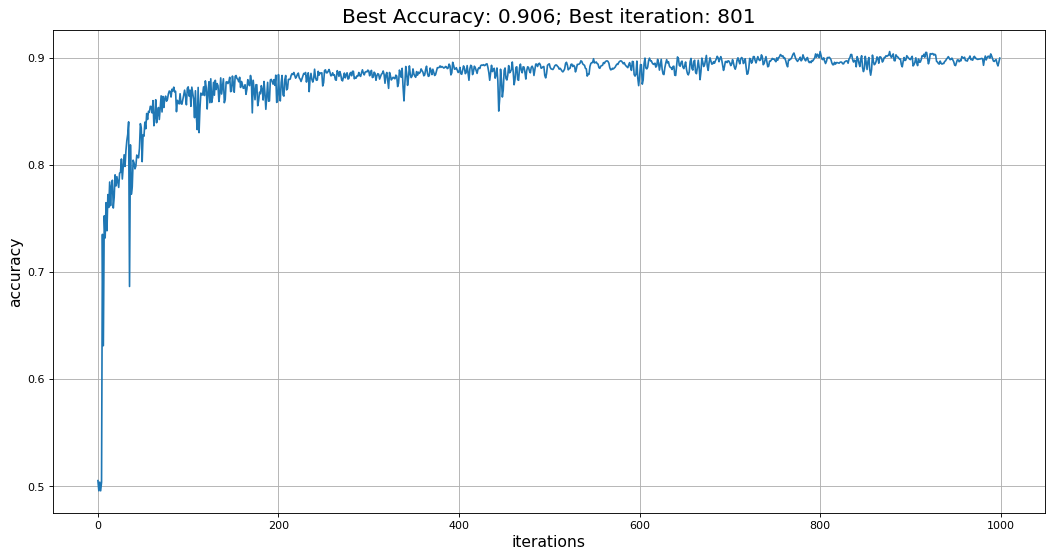

In [34]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(sequence_model.valid_accuracy)
plt.title("Accuracy vs Iterations")
plt.xlabel('iterations', fontsize = 14)
plt.ylabel('accuracy', fontsize = 14)
plt.title("Best Accuracy: "+str(round(sequence_model.best_valid_accuracy,3))+ \
          "; Best iteration: "+str(sequence_model.best_iteration),fontsize = 18)
plt.grid()
plt.show()

## 9. Create submission csv file and analyse results

**Create submission file**

In [31]:
n_folds = 100
test_batch_size = test_size//n_folds
if test_size%n_folds != 0: n_folds +=1
submission_file = "submission.csv"
test_path = input_dir+"test_data.csv"
test_data_reader = pd.read_csv(test_path, chunksize=test_batch_size)
model_path = model_dir+model_name+"-"+str(sequence_model.best_iteration)
sequence_model.create_predictions(model_path, test_data_reader, test_path, 
                                  n_folds, submission_dir, submission_file, generate_batch)

INFO:tensorflow:Restoring parameters from ./model_files/hybrid_multilayer_lstm-801


[100%]|####################################|(number_of_folds_completed:    101)


**Extract test output and compute test predictions**

In [32]:
output = pd.read_csv(input_dir+"test_data.csv")['sentiment'].values
predictions = pd.read_csv(submission_dir+"submission.csv")['sentiments'].values

**Compute accuracy, precision, and recall of the model**

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print("Test accuracy:", round(accuracy_score(output, predictions),3))
print("Test precision:", round(precision_score(output, predictions),3))
print("Test recall:", round(recall_score(output, predictions),3))

Test accuracy: 0.9
Test precision: 0.894
Test recall: 0.908
